# MCMC fitting

Standard imports

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import time

import astropy.io.fits as fits
from astropy.table import Table
from astropy.cosmology import FlatLambdaCDM
from astropy import units
from astropy import constants as cn

import emcee
import corner

And some imports from mcclusters

In [2]:
import mcclusters

# Import observables and model
from mcclusters.observables import xray_sb, xray_t, lensing, lensing_fisher
from mcclusters.models.triaxial_nfw import TriaxialNFW as Model

from mcclusters import initial_values

Initialising models
Initialising observables
Initialising clustersmc


We need to set the cosmology and read in the data. Remember to change the variable _path_ to the path where the data are stored

In [3]:
# Set the cosmology
cosmo = FlatLambdaCDM(H0=70.,Om0=0.3)
redsh = 0.3


# Read data
path = './'

sl_obs, bmap_obs, xtemp_obs = mcclusters.utils.read_data( path, flens='sl_obs.fits',
    fbmap='bmap_obs.fits', fxtemp='xtemp_obs.fits', )


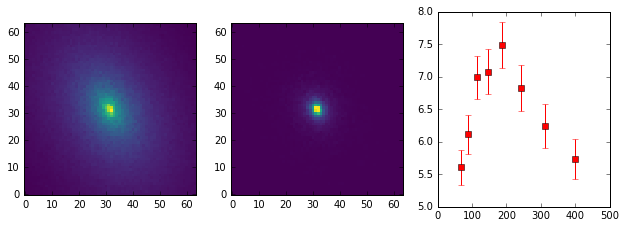

In [4]:
plt.close('all')

fig, ax = plt.subplots( nrows=1, ncols=3, figsize=(3.5*3,3.5) )

ax[0].imshow( sl_obs['avg'].reshape( (64,64) ).T, origin='lower', cmap='viridis', interpolation='none' )

ax[1].imshow( bmap_obs['imhbmap'].T, origin='lower', cmap='viridis', interpolation='none' )

ax[2].errorbar( xtemp_obs['rref_x'], xtemp_obs['kt'], yerr=xtemp_obs['ekt'], fmt='rs' )
ax[2].set_xlim( 0, 500 );

Then we need to create the grid used to integrate the quantities and set some constants

In [5]:
# Number of pixels in the model
Nx = Ny = 64
Nz = 24

side = 1000 * units.kpc
    
xx, yy, zz, rr, pol_coord = mcclusters.utils.create_grid( Nx, Ny, Nz, side )
coord = np.array([xx,yy,zz,rr])
dz = zz[0,0,1] - zz[0,0,0]
scale = side / ( Nx - 1 ) # Pixelsize
print( 'dz: ' + str( dz ) + '\tpx: ' + str( scale ) )



# It's better to do this computations outside the MCMC sampler
rhoc = cosmo.critical_density(redsh)
slscale = rhoc * units.kpc
bmap_obs['scale'] = ( bmap_obs['k'] * units.cm**-6 * units.kpc \
                     * ( bmap_obs['scalebmap'] * units.kpc )**2 ).cgs.value
C0 = 4 * np.pi * cn.G * rhoc * side.unit**2
tscale = cn.u * 0.61 / units.keV

dz: 0.3248240370490104 kpc	px: 15.873015873015873 kpc


We initialise the model and set the variables to fit

In [6]:
model_fit = Model( coord, tscale=( tscale * C0 ).cgs.value )

tofit = [ 'r200', 'c', ]

tpar = initial_values.test()
for v in tpar:
    if v.name in model_fit.__dict__:
        model_fit.__dict__[ v.name ].itemset( v.item() )

    
fitted = [ model_fit.__dict__[v] for v in tofit ]    

Before running the sampler, we need to define the observables to fit

In [7]:
lens = lensing( obs=sl_obs['avg'],
               sigma=sl_obs['sigma'],
               coord=( sl_obs['x'], sl_obs['y'] ),
               mask=sl_obs['mask'],
               scale=slscale.cgs.value,
               model=model_fit )

sb = xray_sb( obs=np.maximum( 1e-25, bmap_obs['imhbmap'] )[bmap_obs['maskbmap']],
             bkg=bmap_obs['bkg'],
             coord=( bmap_obs['xbmap'], bmap_obs['ybmap'] ) ,
             mask=bmap_obs['maskbmap'],
             scale=bmap_obs['scale'],
             model=model_fit )

xt = xray_t( obs=xtemp_obs['kt'],
            sigma=xtemp_obs['ekt'],
            pol_coord=pol_coord,
            model=model_fit,
            coord=( xtemp_obs['rin'], xtemp_obs['rout'] ) )


mc = mcclusters.stat( model_fit, [ lens, xt, sb ], fitted )

---
## Fit

Finally we can run emcee to sample the posterior distribution

In [8]:
iters = 200
nwalkers = 10
threads = 1
tsize = 1
thin = 1


ndim = len( tofit )
pos = np.zeros( ( tsize, nwalkers, ndim ) )
for i,p in enumerate(tofit):
    pos[ :, :, i ] = model_fit.__dict__[p].prior.rvs( size=( tsize, nwalkers ) )


# Initialise PTSampler
sampler = emcee.PTSampler( tsize, nwalkers, ndim, mc.lnprob, mc.lnprior, threads=threads )

tstart = time.time()
for i,result in enumerate( sampler.sample( pos, iterations=iters, storechain=True, thin=thin ), start=1 ):
    print( '\r{0}\t{1:.2f}%\t{2:.0f}s'.format( i, i / iters * 100, time.time() - tstart ), end='', flush=True )


200	100.00%	114s

---
## Outputs

These are the chains

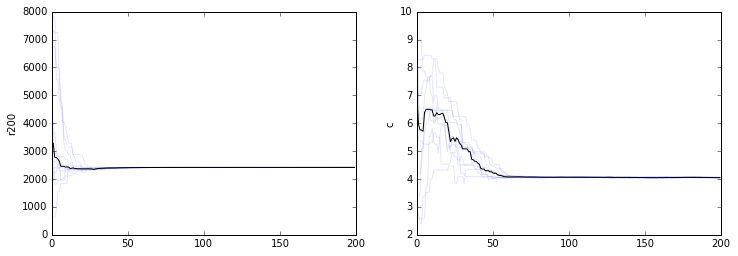

In [12]:
plt.close('all')

chain = sampler.chain[0]

ncols = 2
nrows = int( np.ceil( chain.shape[-1] / ncols ) )
fig, axes = plt.subplots( ncols=ncols, nrows=nrows, figsize=(6*ncols,4*nrows) )

for i,ax in enumerate( axes.flatten()[:len(tofit)] ):
    
    ax.set_ylabel( tofit[i] )
    
    ax.plot( chain[::,:,i].T, 'b', alpha=0.1 );
    ax.plot( np.median( chain[:,:,i], axis=0 ), 'k' );

And the sampled posterior

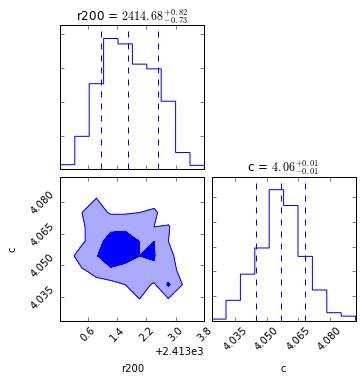

In [10]:
plt.close('all')

levels = 1 - np.exp( - np.array( [ 1, 2 ] )**2 / 2 )
burnin = -100
sample = chain[:,burnin:].reshape( (-1,len(tofit)) )

fig = corner.corner( sample, labels=tofit, bins=10, #range=( ( 2000, 3400 ), ( 2, 6 ) ),
                    quantiles=[0.16,0.5,0.84], levels=levels, smooth=0.,
                    plot_datapoints=False, plot_density=False, fill_contours=True,
                    show_titles=True, color='b', truth_color='g' )


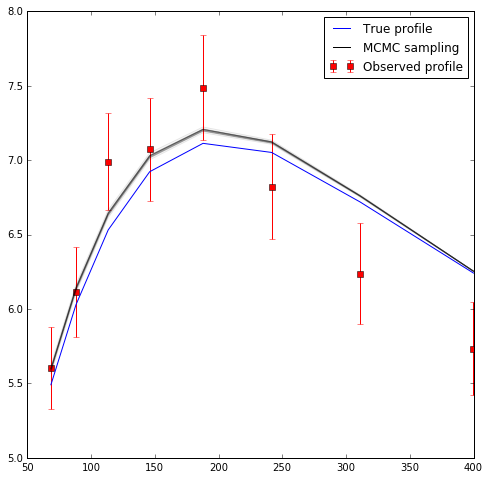

In [11]:
plt.close('all')

plt.figure(figsize=(8,8))

plt.errorbar( xtemp_obs['rref_x'], xtemp_obs['kt'], yerr=xtemp_obs['ekt'], fmt='rs', label='Observed profile' )


for v in tpar:
    if v.name in model_fit.__dict__:
        model_fit.__dict__[ v.name ].itemset( v.item() )
model_fit.update()

plt.plot( xtemp_obs['rref_x'], xt._profile(), 'b-', label='True profile' )



for pars in sample[::50]:
    for name,v in zip( tofit, pars ):
        model_fit.__dict__[ name ].itemset( v )
        
    model_fit.update()
    
    plt.plot( xtemp_obs['rref_x'], xt._profile(), 'k-', alpha=0.1 )

    
plt.plot( (), 'k-', label='MCMC sampling' )
plt.legend(loc=0)
